# **Tutorial on Text as Data**: Deep Learning

Source:  [https://github.com/d-insight/code-bank.git](https://github.com/d-insight/code-bank.git)  
License: [MIT License](https://opensource.org/licenses/MIT). See open source [license](LICENSE) in the Code Bank repository. 

---

For the next section, we will use [Tensorflow Keras](https://www.tensorflow.org/guide/keras/sequential_model), a well known Framework for Deep Learning. Training neural networks, however, if is computationally very expensive and therefore a GPU processor is usually required. You will therefore want to upload this notebook to a virtual macine with access to GPUs. Google provides "Colba" - a free and easy way to get access to a GPU... 

[Colab](https://colab.research.google.com/) is a tool from Google that allows you to share and use a special (Google) type of Jupyter Notebooks on the cloud. It also allows you to use a computer with GPUs for free. You do not need a Google Account to __see__ a notebook, but you will need a Google account (such as a Gmail account) if you want to actually execute code.

To continue with this tutorial, upload the next notebook to Google Colab and continue with it there...

**Activate GPU:**

The default hardware of Google Colab is CPU. So once you have uploaded this notebook and are ready with CoLab, you need to activate GPU. You can enable GPU by clicking on: "Runtime" > "Change runtime type" > "Hardware accelerator" and then select "gpu".

---

## Part 1: Simple Bayes (TFIDF + Bayes)



In [ ]:
import pandas as pd

df = pd.read_csv("https://github.com/dsfm-epfl/data/raw/master/text-as-data/yelp_review.csv")

print(f"Shape: {df.shape}")

df.head(2)

Shape: (150000, 3)


,stars,text,business_id
0,2.0,Be prepared to be greeted by a bland cashier w...,iWGO0_z8Rdwd3ZViapwRhg
1,5.0,The service department saved us today. The rem...,QuYAh94UZzHuy9McaeovKg


Generate the target and split the DataFrame into a `train_df` (80%) and `test_df` (20%).

In [ ]:
df['target'] = (df['stars'] > 4) * 1

from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

Fit a ` TfidfVectorizer` and prepare `X_train`, `X_test`, `Y_train` and `y_test` 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=500)

X_train = tfidf_vectorizer.fit_transform(train_df['text']).toarray()
X_test = tfidf_vectorizer.transform(test_df['text']).toarray()

y_train = train_df['target'].to_numpy()
y_test = test_df['target'].to_numpy()

Train a Bayes model and print accuracy. Our next goal will be to beat such baseline (already good
).

In [ ]:
from sklearn.naive_bayes import GaussianNB
import numpy as np

gnb = GaussianNB()
y_predicted = gnb.fit(X_train, y_train).predict(X_test)

from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_predicted))

0.7687333333333334


### Part 2: Neural Networks

For this task we will use [Tensorflow Keras](https://www.tensorflow.org/guide/keras/sequential_model), a very well known Framework for Deep Learning.


In [ ]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer

Q1: Our first task consist in creating (again) the `X_train` and `X_test` features. This time, instead of using `TfidfVectorizer` we make use [Tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) directly from Keras.

`texts_to_sequences` both tokenize the text and map every token to a number using a dictionary.


In [ ]:
sentences_train = train_df['text']
sentences_test = test_df['text']

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

y_train = train_df['target'].to_numpy()
y_test = test_df['target'].to_numpy()

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
print(f"Vocab size: {vocab_size}")

Vocab size: 95282


Q2: Display the first two values of `X_train`. What does they look like? What's the problem we are facing now?

In [ ]:
print(X_train[:2])

[[104, 42, 20, 1, 1682, 7, 4, 316, 2, 3, 74, 729, 151, 13, 15, 6, 47, 7, 1, 85, 297, 1256, 11, 177, 3, 23, 1, 516, 2682, 997, 17, 25, 73, 44, 516, 18, 87, 22, 2372, 175, 40, 42, 6, 225, 14, 23, 4, 321, 478, 2, 144, 6, 262, 59, 31, 51], [3, 863, 3584, 1588, 75, 3, 142, 4, 320, 544, 7, 1, 297, 1207, 510, 700, 3, 21, 650, 24, 186, 29, 249, 60, 15, 1588, 2, 204, 5, 160, 8, 4, 106, 1, 40, 6, 525, 2, 1, 28, 6, 34, 784, 3, 59, 99, 246, 15, 102, 109, 3, 6, 278, 336, 2, 52, 22, 1819, 15, 102, 11, 12, 260, 358]]


**Answer**

Unlike the TF-IDF matrix, every row of the `X_train` has a different size. We will need to pad every sequences with zeroes so that they have all the same size.

Q3: Pad every sequence using a maxlen of 100 and look at the shape of `X_train`

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train.shape)

(120000, 100)


Q4: We will now define a Neural Network model, we train it and look at the accuracy, did we improved from the baseline?

In [ ]:
import tensorflow

vocab_size = len(tokenizer.word_index) + 1

model = tensorflow.keras.Sequential([
  layers.Embedding(input_dim=vocab_size, output_dim=150, input_length=maxlen),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 150)          14292300  
_________________________________________________________________
dropout (Dropout)            (None, 100, 150)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 150)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 151       
Total params: 14,292,451
Trainable params: 14,292,451
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(
    loss=losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam', 
    metrics=tf.metrics.BinaryAccuracy(threshold=0.0)
)

In [ ]:
# fit = start training

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=5,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=256)

loss, accuracy = model.evaluate(X_train, y_train, verbose=True)

print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=True)

print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/5
318/469 [===================>..........] - ETA: 23s - loss: 0.5681 - binary_accuracy: 0.7159

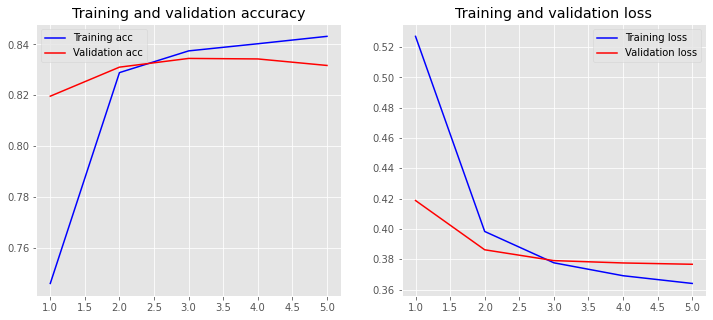

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['binary_accuracy']
    val_acc = history.history['val_binary_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)